# DATA IMPORT

In [223]:
import pandas as pd
import numpy as np

df_credit = pd.read_csv('credits.csv')
df_rating = pd.read_csv('ratings.csv')
df_movie = pd.read_csv('movies_metadata.csv')
df_keywords = pd.read_csv('keywords.csv')


C:\Users\Sang\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Preprocessing

In [226]:
df_movie = df_movie[['id', 'original_title', 'title', 'belongs_to_collection', 
                     'budget', 'genres', 'original_language', 'popularity',
                     'production_companies', 'production_countries', 'revenue', 
                     'runtime', 'spoken_languages', 'status', 'vote_average',
                     'vote_count']]

df_rating = df_rating[['movieId', 'rating']]



In [228]:
import ast

def convertType(x, typ):
    try:
        return typ(x)
    except ValueError:
        return np.NaN

df_movie['genres_parsed'] = df_movie['genres'].apply(lambda x: [d['name'] for d in ast.literal_eval(x)])
# df_movie['production_countries'] = df_movie['production_countries'].apply(lambda x: d['iso_3166_1'] for d in ast.literal_eval(x))

# convert boolean belongs_to_collection col to integer col with 1 and 0 value
df_movie['is_collection'] = df_movie['belongs_to_collection'].isnull()
df_movie['is_collection'] = df_movie['is_collection'].apply(lambda x: 1 if x==True else 0)

# convert boolean adult col to integer col with 1 and 0 value
# print(df_movie['adult'])
# df_movie['adult'] = df_movie['adult'].apply(lambda x: 1 if x==True else 0)
df_movie['popularity'] = df_movie['popularity'].apply(lambda x: convertType(x, float))

df_movie['budget'] = df_movie['budget'].apply(lambda x: convertType(x, int))

# DATA ADVERTISING AND BASIC ANALYSIS

C:\Users\Sang\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


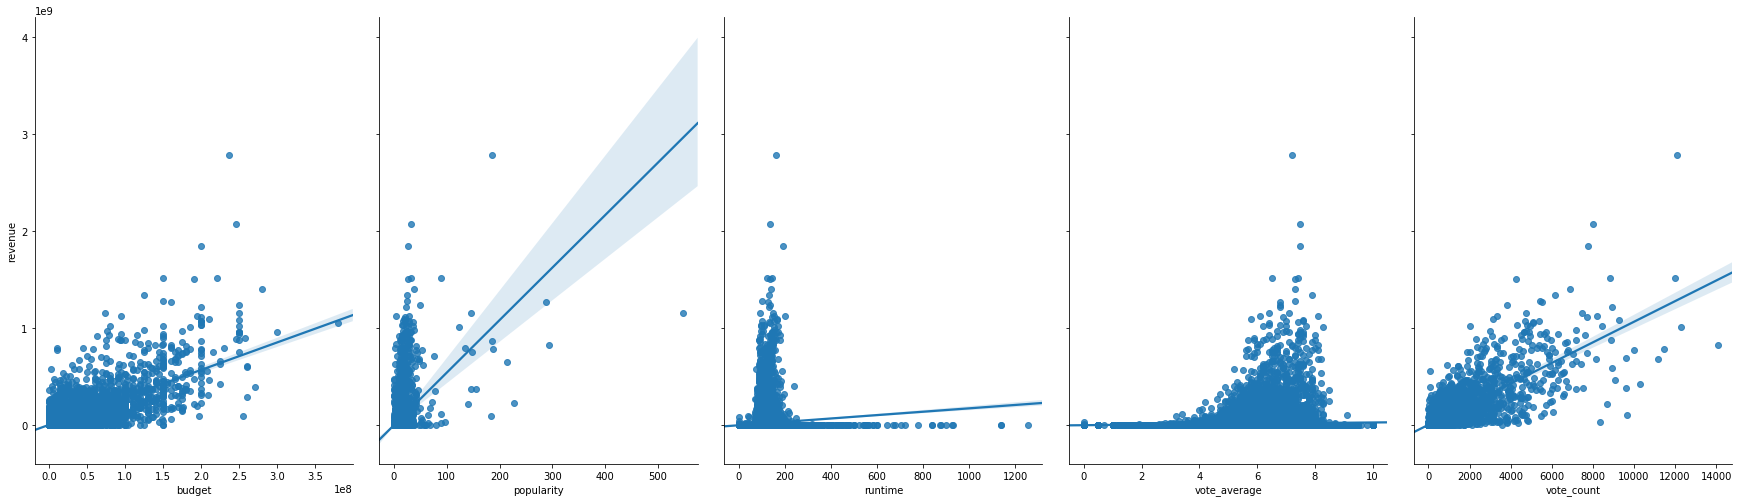

In [229]:
import seaborn as sns
x = ['budget', 'popularity', 'runtime', 'vote_average', 'vote_count']
# plot relationship to revenue and plotting the Least Squares Line
sns.pairplot(df_movie, x_vars=x, y_vars='revenue', kind='reg', height=7, aspect=0.7)

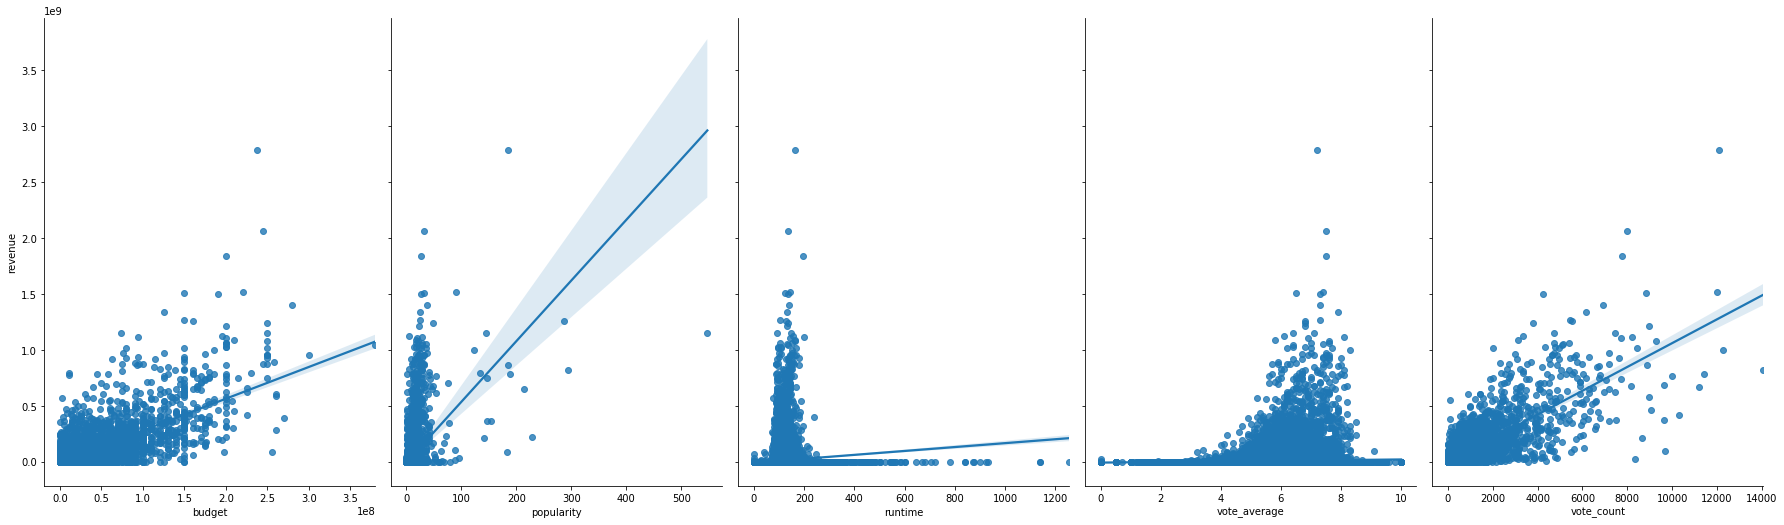

In [7]:
# filter out 0 revenue movies
import seaborn as sns
# plot relationship to revenue
sns.pairplot(df_movie, 
             x_vars=x, y_vars='revenue', kind='reg', height=7, aspect=0.7)

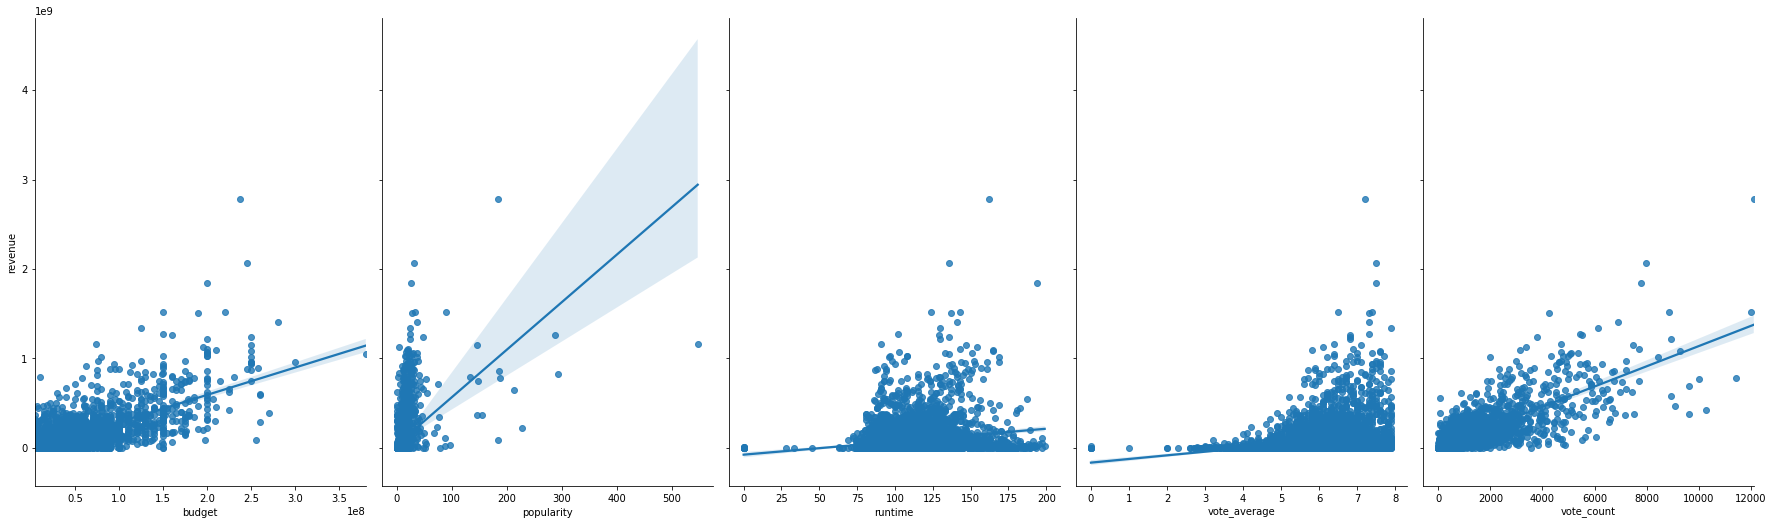

In [8]:
sns.pairplot(df_movie[np.logical_and(df_movie['vote_average'] < 8,
                                     np.logical_and(df_movie['runtime'] < 200, df_movie['budget'] > 4224578))], 
                      x_vars=x, y_vars='revenue', kind='reg', height=7, aspect=0.7)

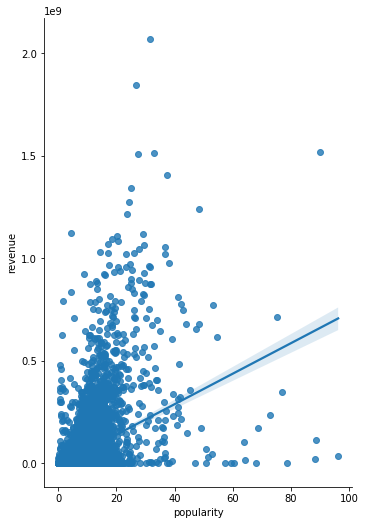

In [9]:
# popularity has extremely big r^2 value
sns.pairplot(df_movie[df_movie['popularity'] < 100], x_vars=['popularity'], y_vars='revenue', kind='reg', height=7, aspect=0.7)

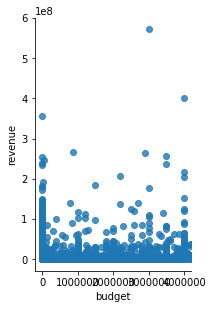

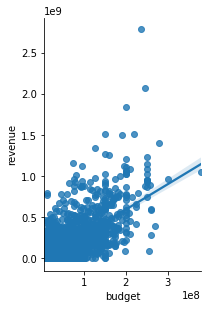

In [10]:
# too much variability in low budget films. Only going to target mainstream films for predictability.
sns.pairplot(df_movie[df_movie['budget'] <= 4224578], x_vars=['budget'], y_vars='revenue', kind='reg', height=4, aspect=0.7)
sns.pairplot(df_movie[df_movie['budget'] > 4224578], x_vars=['budget'], y_vars='revenue', kind='reg', height=4, aspect=0.7)

44864
339


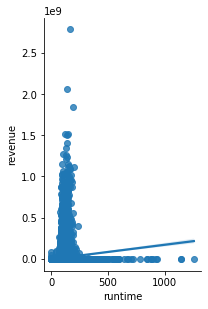

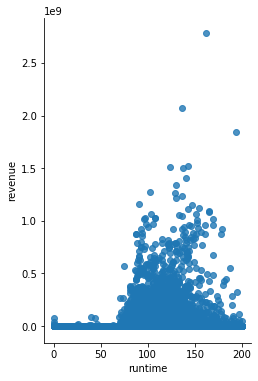

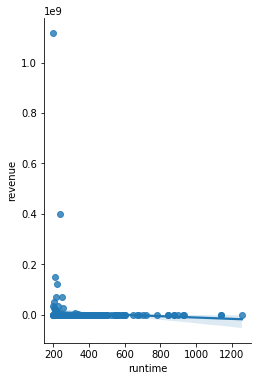

In [11]:
# too short or too long of films have really low revenue. Gaussian and therefore can't use linear regression 
# may need to cut off the films that are too long
sns.pairplot(df_movie, x_vars=['runtime'], y_vars='revenue', kind='reg', height=4, aspect=0.7)
sns.pairplot(df_movie[df_movie['runtime'] <= 200], x_vars=['runtime'], y_vars='revenue', kind='reg', height=5, aspect=0.7)
print(len(df_movie[df_movie['runtime'] <= 200]))
sns.pairplot(df_movie[df_movie['runtime'] > 200], x_vars=['runtime'], y_vars='revenue', kind='reg', height=5, aspect=0.7)
print(len(df_movie[df_movie['runtime'] > 200]))

# FEATURE EXTRACTION

In [295]:
df_movie_cleaned = df_movie

movie_cols = ['id', 'title', 'revenue', 'is_collection', 'popularity', 
              'vote_average', 'vote_count', 'runtime', 'budget', 'genres']

# movie_cols = ['id', 'title', 'revenue', 'is_collection', 'adult', 'popularity', 
#               'vote_average', 'vote_count', 'runtime', 'budget']

filter_outlier = np.logical_and(df_movie_cleaned['revenue'] > 0, np.logical_and(df_movie_cleaned['runtime'] < 200, df_movie_cleaned['budget'] > 224578))
df_movie_cleaned = df_movie_cleaned[movie_cols]
df_movie_cleaned = df_movie_cleaned[filter_outlier].reset_index(drop=True)
df_movie_cleaned = df_movie_cleaned.reset_index(drop=True)

# one hot encoding on categorical features
# original language
# DROP_FIRST needed because if the first category is implied if all other cols are 0.
# df_movie_cleaned = df_movie_cleaned.join(pd.get_dummies(df_movie[['id', 'original_language']], 
#                                                         columns=['original_language'],
#                                                         prefix='lang',
#                                                         drop_first=True))
# print(pd.get_dummies(df_movie[['original_language']], 
#                                                         columns=['original_language'],
#                                                         prefix='lang',
#                                                         drop_first=True))

df_movie_cleaned['genres'] = df_movie_cleaned['genres'].apply(lambda x: x if ast.literal_eval(x) else "[{\'name\': \'unknown\'}]")
df_movie_cleaned['genres'] = df_movie_cleaned['genres'].apply(lambda x: [d['name'].replace(' ', '_').lower()+'_genre' \
                                                                         for d in ast.literal_eval(x) if ast.literal_eval(x)])

df_movie_cleaned = df_movie_cleaned.drop('genres', 1).join(
        pd.get_dummies(
            pd.DataFrame(df_movie_cleaned.genres.tolist()).stack()
        ).astype(int).sum(level=0)
    )

# Drop rows with any NAN

df_movie_cleaned = df_movie_cleaned.dropna()

df_movie_cleaned.astype({
    'is_collection': 'int32',
    'popularity': 'float',
    'revenue': 'float',
    'vote_average': 'float',
    'vote_count': 'float',
    'runtime': 'float',
    'budget':  'int32'
})


# df_movie_cleaned = df_movie_cleaned[df_movie_cleaned['revenue'] != 0]


df_2 =  df_movie_cleaned.drop(['id', 'title', 'is_collection', 'unknown_genre'], axis=1)
df_movie_cleaned = df_movie_cleaned[df_movie_cleaned['tv_movie_genre'] == 0]
df_movie_cleaned = df_movie_cleaned[df_movie_cleaned['documentary_genre'] == 0]

print('Dataset length:{}'.format(len(df_movie_cleaned)))
print(df_movie_cleaned.columns)


Dataset length:5143
Index(['id', 'title', 'revenue', 'is_collection', 'popularity', 'vote_average',
       'vote_count', 'runtime', 'budget', 'action_genre', 'adventure_genre',
       'animation_genre', 'comedy_genre', 'crime_genre', 'documentary_genre',
       'drama_genre', 'family_genre', 'fantasy_genre', 'foreign_genre',
       'history_genre', 'horror_genre', 'music_genre', 'mystery_genre',
       'romance_genre', 'science_fiction_genre', 'thriller_genre',
       'tv_movie_genre', 'unknown_genre', 'war_genre', 'western_genre'],
      dtype='object')


# LINEAR REGRESSION MODEL

# MODEL WITH GENRES

In [296]:
for col in df_2.columns:
    if '_genre' in col:
        dict_genres[col] = len(df_2[df_2[col]==1])
        
dict_genres

{'action_genre': 1383,
 'adventure_genre': 944,
 'animation_genre': 288,
 'comedy_genre': 1794,
 'crime_genre': 839,
 'documentary_genre': 51,
 'drama_genre': 2476,
 'family_genre': 523,
 'fantasy_genre': 501,
 'foreign_genre': 29,
 'history_genre': 219,
 'horror_genre': 557,
 'music_genre': 184,
 'mystery_genre': 435,
 'romance_genre': 964,
 'science_fiction_genre': 621,
 'thriller_genre': 1470,
 'tv_movie_genre': 1,
 'unknown_genre': 11,
 'war_genre': 194,
 'western_genre': 86}

In [310]:
df_2 =  df_movie_cleaned.drop(['id', 'title', 'is_collection', 'unknown_genre', 'tv_movie_genre', 'documentary_genre'], axis=1)

# normalize genres
# dict_genres = dict()
# tot = 0
# for col in df_2.columns:
#     if '_genre' in col:
#         dict_genres[col] = len(df_2[df_2[col]==1])
#         tot += dict_genres[col]
        
# print(dict_genres)
# print(tot)

# for col in df_2.columns:
#     if '_genre' in col:
#         df_2[col] = df_2[col] * dict_genres[col]/tot

x = df_2.iloc[:, 1:].values
y = df_2.iloc[:, 0].values

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x_train, y_train)

# Make Prediction
df_result = pd.DataFrame()
y_predicted = regressor.predict(x_test)
combined = np.concatenate((np.vstack((y_test)), x_test), axis=1)
df_result = pd.DataFrame(data=combined, columns=df_2.columns)
y_predicted = y_predicted.clip(min=0) # revenue can't be less than 0
regressor.score(x_test, y_test)
# df_result['difference'] = np.absolute(df_result['predicted_revenue']-df_result['revenue'])/df_result['revenue']


0.742214542803594

In [311]:
import math
print('interecept: {}'.format(regressor.intercept_))
print('COEFFICIENTS')
d_coefficient = {col:regressor.coef_[i] for i,col in enumerate(df_2.iloc[:, 1:].columns)}
# print(list(zip(df_movie_cleaned.iloc[:, 1:].columns, regressor.coef_)))
l_coef = sorted(list(zip(df_2.iloc[:, 1:].columns, regressor.coef_)),
                key=lambda x: x[1], reverse=True)
# print(sorted(list(zip(df_movie_cleaned.iloc[:, 1:].columns, regressor.coef_)), key=lambda x: abs(x[1]), reverse=True))
for coef in l_coef:
    print('{}: {}'.format(coef[0], coef[1]))

interecept: -47343775.8508662
COEFFICIENTS
animation_genre: 27015214.16594056
family_genre: 23663019.576118153
romance_genre: 11670173.121819375
adventure_genre: 11442820.845313063
music_genre: 8741631.343205938
foreign_genre: 8513794.75800388
horror_genre: 7353027.24668044
comedy_genre: 4737463.129037632
fantasy_genre: 4534621.219871911
popularity: 1045985.8574722076
vote_average: 632767.3623528382
runtime: 274566.1876808388
vote_count: 61472.55368879837
budget: 1.6136567280147076
mystery_genre: -2460679.652234034
action_genre: -4923599.081078168
thriller_genre: -7861236.456156768
war_genre: -8930634.993594889
crime_genre: -8936234.362014038
drama_genre: -11614294.294873223
history_genre: -11681513.206180135
science_fiction_genre: -27570665.292147677
western_genre: -34136008.67701476


In [312]:
from statsmodels.api import OLS
x_ols = df_2.iloc[:, 1:]
y_ols = df_2.iloc[:, 0]
ols_model = OLS(y_ols,x_ols).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     847.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):               0.00
Time:                        21:02:52   Log-Likelihood:            -1.0137e+05
No. Observations:                5143   AIC:                         2.028e+05
Df Residuals:                    5120   BIC:                         2.029e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
popularity             9.232e+05   9.95e+04      9.279      0.000    7.28e+05    1.12e+06
vote_average          -4.841e+06    1.2e+06     -4.044      0.000   -7.19e+06   -2.49e+06
vote_count             6.698e+04   1345.751     49.770      0.000    6.43e+04    6.96e+04
runtime                1.773e+05   6.65e+04      2.667      0.008     4.7e+04    3.08e+05
budget                    1.6271      0.043     38.070      0.000       1.543       1.711
action_genre          -5.994e+06   3.35e+06     -1.788      0.074   -1.26e+07    5.78e+05
adventure_genre        1.426e+07   3.79e+06      3.766      0.000    6.83e+06    2.17e+07
animation_genre        2.193e+07   6.85e+06      3.201      0.001     8.5e+06    3.54e+07
comedy_genre           3.246e+05   2.97e+06      0.109      0.913   -5.51e+06    6.16e+06
crime_genre           -9.953e+06   3.72e+06     -2.674      0.008   -1.73e+07   -2.66e+06
drama_genre           -1.174e+07   3.09e+06     -3.795      0.000   -1.78e+07   -5.67e+06
family_genre           1.902e+07   5.35e+06      3.554      0.000    8.53e+06    2.95e+07
fantasy_genre         -1.696e+06   4.49e+06     -0.377      0.706   -1.05e+07    7.11e+06
foreign_genre          5.142e+06   1.72e+07      0.299      0.765   -2.86e+07    3.89e+07
history_genre         -8.632e+06    6.7e+06     -1.288      0.198   -2.18e+07    4.51e+06
horror_genre           3.419e+06   4.41e+06      0.776      0.438   -5.22e+06    1.21e+07
music_genre            9.514e+06   6.93e+06      1.373      0.170   -4.07e+06    2.31e+07
mystery_genre         -6.942e+06   4.69e+06     -1.479      0.139   -1.61e+07    2.26e+06
romance_genre          1.174e+07   3.44e+06      3.412      0.001       5e+06    1.85e+07
science_fiction_genre -2.991e+07    4.1e+06     -7.297      0.000   -3.79e+07   -2.19e+07
thriller_genre        -7.222e+06   3.29e+06     -2.194      0.028   -1.37e+07   -7.68e+05
war_genre              -9.44e+06   6.92e+06     -1.365      0.172    -2.3e+07    4.12e+06
western_genre         -3.098e+07   9.71e+06     -3.192      0.001      -5e+07    -1.2e+07
==============================================================================
Omnibus:                     3713.042   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           260718.497
Skew:                           2.793   Prob(JB):                         0.00
Kurtosis:                      37.430   Cond. No.                     7.28e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.28e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# MODEL WITH ACTORS

In [ ]:
df_movie_cleaned = df_movie

# movie_cols = ['id', 'title', 'revenue', 'is_collection', 'adult', 'popularity', 
#               'vote_average', 'vote_count', 'runtime', 'budget', 'genres']

movie_cols = ['id', 'title', 'revenue', 'is_collection', 'adult', 'popularity', 
              'vote_average', 'vote_count', 'runtime', 'budget']

filter_outlier = np.logical_and(df_movie_cleaned['revenue'] > 0, np.logical_and(df_movie_cleaned['runtime'] < 200, df_movie_cleaned['budget'] > 224578))
df_movie_cleaned = df_movie_cleaned[movie_cols]
df_movie_cleaned = df_movie_cleaned[filter_outlier].reset_index(drop=True)
df_movie_cleaned = df_movie_cleaned.reset_index(drop=True)

# one hot encoding on categorical features
# original language
# DROP_FIRST needed because if the first category is implied if all other cols are 0.
# df_movie_cleaned = df_movie_cleaned.join(pd.get_dummies(df_movie[['id', 'original_language']], 
#                                                         columns=['original_language'],
#                                                         prefix='lang',
#                                                         drop_first=True))
# print(pd.get_dummies(df_movie[['original_language']], 
#                                                         columns=['original_language'],
#                                                         prefix='lang',
#                                                         drop_first=True))

# df_movie_cleaned['genres'] = df_movie_cleaned['genres'].apply(lambda x: x if ast.literal_eval(x) else "[{\'name\': \'unknown\'}]")
# df_movie_cleaned['genres'] = df_movie_cleaned['genres'].apply(lambda x: [d['name'].replace(' ', '_').lower() \
#                                                                          for d in ast.literal_eval(x) if ast.literal_eval(x)])

# df_movie_cleaned = df_movie_cleaned.drop('genres', 1).join(
#         pd.get_dummies(
#             pd.DataFrame(df_movie_cleaned.genres.tolist()).stack()
#         ).astype(int).sum(level=0)
#     )

# Drop rows with any NAN

df_movie_cleaned = df_movie_cleaned.dropna()

df_movie_cleaned.astype({
    'is_collection': 'int32',
    'adult': 'int32',
    'popularity': 'float',
    'revenue': 'float',
    'vote_average': 'float',
    'vote_count': 'float',
    'runtime': 'float',
    'budget':  'int32'
})


# df_movie_cleaned = df_movie_cleaned[df_movie_cleaned['revenue'] != 0]

print('Dataset length:{}'.format(len(df_movie_cleaned)))

print(df_movie_cleaned.columns)


In [316]:
# categorical_feature_mask = df_movie.dtypes==object
# categorical_feature_mask
df_credit.id.astype('object')
df_movie_cleaned.id.astype('object')
df_credit.id = df_credit.id.apply(lambda x: str(x))

import ast
df_merged = df_movie_cleaned.merge(df_credit, how='left', on='id')
df_merged['cast_list'] = df_merged['cast'].\
    apply(lambda x: [cast['name'].strip().replace(' ','_')+'_actor' for cast in ast.literal_eval(x)[:3]])
df_merged = df_merged.drop('cast_list', 1).join(
    pd.get_dummies(
        pd.DataFrame(df_merged.cast_list.tolist()).stack()
    ).astype(int).sum(level=0)
).fillna(0).reset_index(drop=True)
# df_merged_finished[df_merged_finished.isnull().any(axis=1)]

df_merged = df_merged.drop(['id', 'title', 'crew', 'cast'], axis=1)
x = df_merged.iloc[:, 1:].values
y = df_merged.iloc[:, 0].values
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x_train, y_train)
regressor.score(x_test, y_test)

0.138042801370311

In [317]:
import math
print('interecept: {}'.format(regressor.intercept_))
print('COEFFICIENTS')
d_coefficient = {col:regressor.coef_[i] for i,col in enumerate(df_merged.iloc[:, 1:].columns)}
# print(list(zip(df_movie_cleaned.iloc[:, 1:].columns, regressor.coef_)))
l_coef = sorted(list(zip(df_merged.iloc[:, 1:].columns, regressor.coef_)),
                key=lambda x: x[1], reverse=True)
# print(sorted(list(zip(df_movie_cleaned.iloc[:, 1:].columns, regressor.coef_)), key=lambda x: abs(x[1]), reverse=True))
for coef in l_coef:
    print('{}: {}'.format(coef[0], coef[1]))

interecept: -57144527.73991078
COEFFICIENTS
Daisy_Ridley_actor: 1188231115.3833866
Frances_Fisher_actor: 1110831759.04389
Dagmara_Domińczyk_actor: 756493558.4269203
Ludivine_Sagnier_actor: 572010880.9587847
Eric_Stonestreet_actor: 542158095.9864107
Ben_Huber_actor: 520914927.41070986
Irrfan_Khan_actor: 503019806.252135
Maia_Morgenstern_actor: 482003088.4834165
Lainie_Kazan_actor: 466088561.67664194
Trey_Parker_actor: 450560793.8325409
Robert_MacNaughton_actor: 442655350.9918024
Feryna_Wazheir_actor: 429145451.47709846
Robert_Baker_actor: 414338209.25555754
Zachary_Levi_actor: 400940610.4842338
Raquel_Welch_actor: 374811655.7558853
Maria_Pitillo_actor: 372700200.31396496
Tony_Goldwyn_actor: 361145881.8728915
Charlotte_Lewis_actor: 352214617.80035603
Dylan_Walsh_actor: 341223512.2872091
Nikitin_Dheer_actor: 336775725.6763764
Adam_Campbell_actor: 336739903.4503904
Skandar_Keynes_actor: 334228212.4660146
Tracey_Ullman_actor: 318985950.26438695
Vidya_Balan_actor: 318231235.6360037
Barbra_St

Kevin_Farley_actor: 56666846.72020078
Telly_Savalas_actor: 56571700.59781155
Brian_Benben_actor: 56514039.52116575
Betsy_Brantley_actor: 56514028.89208069
Art_Carney_actor: 56111653.2739069
Josh_Holloway_actor: 55966563.9921708
Julie_Kavner_actor: 55910156.09710484
Nancy_Cartwright_actor: 55910155.78605669
Dan_Castellaneta_actor: 55910152.92202114
Tim_McGraw_actor: 55563653.396380894
Matt_LeBlanc_actor: 55509259.96836684
Barbara_Eden_actor: 55361760.88006428
Josh_Zuckerman_actor: 55273306.44634412
Warren_Oates_actor: 55192097.57009204
Luenell_actor: 55034505.61714628
Bruce_Willis_actor: 54798324.96210569
Jeremy_Piven_actor: 54782001.04284629
Nick_Cassavetes_actor: 54768644.84249402
Sherilyn_Fenn_actor: 54768644.84249402
Larry_the_Cable_Guy_actor: 54686112.02309891
James_Cromwell_actor: 54411539.6343512
Mia_Wasikowska_actor: 54328011.37671531
James_Hong_actor: 54205417.55419098
Michael_Nouri_actor: 53904031.518771246
Jeremy_Davies_actor: 53705121.15397587
Cameron_Bright_actor: 53303334.

Lindy_Booth_actor: -7020804.45171181
Jared_Padalecki_actor: -7020805.24010188
Kelli_Maroney_actor: -7060729.893523074
Robert_Beltran_actor: -7060732.976007252
Vladimir_Ilin_actor: -7105933.800222224
Esther_Wurmfeld_actor: -7108243.53594488
Tovah_Feldshuh_actor: -7108244.8434494855
Jennifer_Westfeldt_actor: -7108245.533247893
Lesley-Anne_Down_actor: -7126504.722717736
Suvalakshmi_actor: -7134596.128317464
Jenna_Dewan_actor: -7152635.672268589
Jenny_Agutter_actor: -7196270.276740792
Jeff_Speakman_actor: -7226280.265953797
John_Dye_actor: -7226280.347835514
Hal_Holbrook_actor: -7317836.221434101
Rod_Steiger_actor: -7339339.977674627
Steve_Carell_actor: -7347159.563122483
Charlie_Yeung_actor: -7436458.051720127
Wang_Baoqiang_actor: -7436458.517488211
Elia_Suleiman_actor: -7446222.496270027
Saleh_Bakri_actor: -7446222.610148221
Ali_Suliman_actor: -7446224.48010283
Danneel_Ackles_actor: -7495044.153144041
Alex_O'Loughlin_actor: -7495049.676784826
Anna_Khilkevich_actor: -7518423.755660076
Sve

Richard_Crenna_actor: -90528481.08685367
Johnny_Depp_actor: -90590177.06058133
Ann_Miller_actor: -90640233.72990409
Laura_Harring_actor: -90640234.04610983
Kevin_Hart_actor: -90658922.84118605
Ty_Simpkins_actor: -90810582.46480675
Jill_Scott_actor: -90873298.42986378
Gregory_Itzin_actor: -90954848.77373439
Marilyn_Monroe_actor: -91017744.38689294
Ian_McShane_actor: -91032658.93979064
Dolph_Lundgren_actor: -91133600.54873274
Irene_Dunne_actor: -91203346.05534905
Swarnamalya_actor: -91311787.42925553
Sebastian_Koch_actor: -91325607.2274906
Roy_Chiao_actor: -91336249.80007735
Bolo_Yeung_actor: -91336253.03320375
Mariel_Hemingway_actor: -91354359.2000468
Dennis_Quaid_actor: -91402705.68884692
Isla_Fisher_actor: -91476183.17390874
Lorna_Luft_actor: -91489893.3954354
Maxwell_Caulfield_actor: -91489894.2479106
Bonnie_Hunt_actor: -91671070.14640804
Nehemiah_Persoff_actor: -92132610.25083244
Esha_Deol_actor: -92147530.81236327
James_Coburn_actor: -92238051.59200288
Amy_Stewart_actor: -92419502.

In [315]:
# R^2 value of the model
print(regressor.score(x_test, y_test))
# calculate MAE, MSE, 
# from sklearn import metrics
# print(y_predicted.mean())
# print(metrics.mean_absolute_error(y_test, y_predicted))
# print(metrics.mean_squared_error(y_test, y_predicted))
# print(np.sqrt(metrics.mean_squared_error(y_test, y_predicted)))

0.138042801370311


## USING OLS INSTEAD OF SCIKIT LEARN

In [279]:
from statsmodels.api import OLS
x_ols = df_2.iloc[:, 1:]
y_ols = df_2.iloc[:, 0]
ols_model = OLS(y_ols,x_ols).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     3716.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):               0.00
Time:                        20:54:26   Log-Likelihood:            -1.0249e+05
No. Observations:                5195   AIC:                         2.050e+05
Df Residuals:                    5190   BIC:                         2.050e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
popularity    9.463e+05   1.01e+05      9.377      0.000    7.48e+05    1.14e+06
vote_average -2.328e+06   1.05e+06     -2.214      0.027   -4.39e+06   -2.66e+05
vote_count    6.502e+04   1332.721     48.786      0.000    6.24e+04    6.76e+04
runtime      -5.741e+04   6.05e+04     -0.949      0.343   -1.76e+05    6.11e+04
budget           1.7392      0.039     44.737      0.000       1.663       1.815
==============================================================================
Omnibus:                     3661.218   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           229131.241
Skew:                           2.725   Prob(JB):                         0.00
Kurtosis:                      35.076   Cond. No.                     4.38e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.38e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

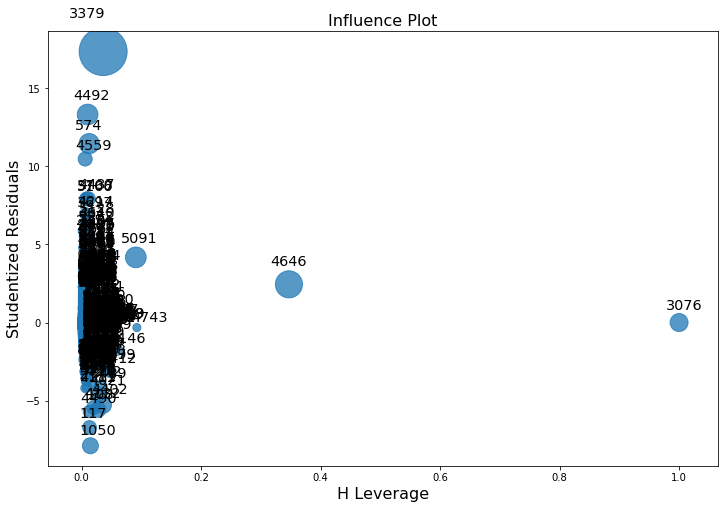

In [261]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(ols_model, ax=ax, criterion="cooks")

In [14]:
import re

df_credit
import ast
keywords = ast.literal_eval(df_keywords.iloc[0]['keywords'])
keywords
# re.split("},", df_credit.iloc[0]['cast'].strip(']['))
# df_credit.iloc[0]['cast'].strip('][')
# pd.to_numeric(df_movie['popularity'])
# df_movie.iloc[35587]

[{'id': 931, 'name': 'jealousy'},
 {'id': 4290, 'name': 'toy'},
 {'id': 5202, 'name': 'boy'},
 {'id': 6054, 'name': 'friendship'},
 {'id': 9713, 'name': 'friends'},
 {'id': 9823, 'name': 'rivalry'},
 {'id': 165503, 'name': 'boy next door'},
 {'id': 170722, 'name': 'new toy'},
 {'id': 187065, 'name': 'toy comes to life'}]

In [ ]:
df_2 =  df_movie_cleaned.drop(['id', 'title', 'unknown'], axis=1)
x = df_2.iloc[:, 1:].values
y = df_2.iloc[:, 0].values

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x_train, y_train)

# Make Prediction
df_result = pd.DataFrame()
y_predicted = regressor.predict(x_test)
combined = np.concatenate((np.vstack((y_test)), x_test), axis=1)
df_result = pd.DataFrame(data=combined, columns=df_2.columns)
y_predicted = y_predicted.clip(min=0) # revenue can't be less than 0
regressor.score(x_test, y_test)
# df_result['difference'] = np.absolute(df_result['predicted_revenue']-df_result['revenue'])/df_result['revenue']


In [324]:
df_movie.sort_values('revenue')

,id,original_title,title,belongs_to_collection,budget,genres,original_language,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,status,vote_average,vote_count,genres_parsed,is_collection
22731,83564,La luna,La luna,NaN,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",en,7.331398,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",0.000000e+00,7.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,8.0,257.0,"[Animation, Family]",1
29873,61777,Dear America: Letters Home from Vietnam,Dear America: Letters Home from Vietnam,NaN,0.0,"[{'id': 99, 'name': 'Documentary'}, {'id': 107...",en,0.733091,"[{'name': 'Dear America', 'id': 7031}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",0.000000e+00,83.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,6.8,4.0,"[Documentary, War]",1
29874,201419,Code Black,Code Black,NaN,0.0,"[{'id': 99, 'name': 'Documentary'}]",en,0.674411,[],[],0.000000e+00,88.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,5.6,8.0,[Documentary],1
29875,173165,The King of Arcades,The King of Arcades,NaN,175000.0,"[{'id': 99, 'name': 'Documentary'}]",en,0.888050,"[{'name': 'Tiedebaby Films', 'id': 33167}]","[{'iso_3166_1': 'US', 'name': 'United States o...",0.000000e+00,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,5.4,7.0,[Documentary],1
29876,69129,Anonymous Rex,Anonymous Rex,NaN,0.0,"[{'id': 28, 'name': 'Action'}, {'id': 14, 'nam...",en,0.787374,[],[],0.000000e+00,120.0,[],Released,4.4,8.0,"[Action, Fantasy, Science Fiction, TV Movie]",1
29877,129360,"Usain Bolt, La Légende","Usain Bolt, La Légende",NaN,0.0,[],en,0.431827,[],[],0.000000e+00,60.0,[],Released,6.2,5.0,[],1
29878,134255,The American Scream,The American Scream,NaN,0.0,"[{'id': 99, 'name': 'Documentary'}]",en,1.129757,[],[],0.000000e+00,91.0,[],Released,7.1,8.0,[Documentary],1
29879,326284,Pound of Flesh,Pound of Flesh,NaN,7500000.0,"[{'id': 28, 'name': 'Action'}]",en,5.135262,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",0.000000e+00,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,5.4,64.0,[Action],1
29880,218482,Stripped,Stripped,NaN,0.0,[],en,1.092963,[],[],0.000000e+00,71.0,[],Released,7.0,6.0,[],1
29881,242065,Lucia de B.,Accused,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",nl,2.770409,[{'name': 'Nederlandse Christelijke Radio-Vere...,"[{'iso_3166_1': 'SE', 'name': 'Sweden'}, {'iso...",0.000000e+00,97.0,"[{'iso_639_1': 'nl', 'name': 'Nederlands'}]",Released,6.6,30.0,"[Drama, Thriller]",1


In [323]:
np.isin( df_movie['title'], '')

array(False)